In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Prepare your dataset
data_dir = '/kaggle/input/crop-diseases-dataset'
train_dir = '/kaggle/input/crop-diseases-dataset/train'
test_dir = '/kaggle/input/crop-diseases-dataset/test'

In [3]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split the dataset into training, validation, and testing sets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
total_samples = len(train_dataset)
train_split = int(0.7 * total_samples)
val_split = int(0.2 * total_samples)
test_split = total_samples - train_split - val_split

train_dataset, val_dataset, _ = random_split(train_dataset, [train_split, val_split, test_split])
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [4]:
# Data loaders
batch_size = 32
num_workers = 2
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=pin_memory, prefetch_factor=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory, prefetch_factor=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory, prefetch_factor=2
)

In [5]:
# Load the MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
num_classes = len(train_dataset.dataset.classes)  # Access classes attribute from train_dataset.dataset
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 73.8MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
# Define the training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [7]:
# Train the model
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

scaler = amp.GradScaler()

best_val_loss = float('inf')
best_val_accuracy = 0.0

accumulation_steps = 4  # Define the number of accumulation steps

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()
            t.set_postfix({"Loss": loss.item()})

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_loader, desc="Validation", unit="batch"):
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

            _, val_predicted = torch.max(val_outputs, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_accuracy = val_correct_predictions / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    scheduler.step(val_epoch_loss)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_epoch_loss:.4f} - Validation Accuracy: {val_epoch_accuracy:.4f}")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_val_accuracy = val_epoch_accuracy
        torch.save(model.state_dict(), "best_model.pth")

Validation: 100%|██████████| 82/82 [00:41<00:00,  1.98batch/s]


Epoch 1/10 - Validation Loss: 0.5922 - Validation Accuracy: 0.8018


Validation: 100%|██████████| 82/82 [00:37<00:00,  2.21batch/s]


Epoch 2/10 - Validation Loss: 0.3414 - Validation Accuracy: 0.8606


Validation: 100%|██████████| 82/82 [00:36<00:00,  2.24batch/s]


Epoch 3/10 - Validation Loss: 0.2490 - Validation Accuracy: 0.9113


Validation: 100%|██████████| 82/82 [00:38<00:00,  2.16batch/s]


Epoch 4/10 - Validation Loss: 0.2507 - Validation Accuracy: 0.9144


Validation: 100%|██████████| 82/82 [00:37<00:00,  2.20batch/s]


Epoch 5/10 - Validation Loss: 0.2358 - Validation Accuracy: 0.9021


Validation: 100%|██████████| 82/82 [00:36<00:00,  2.24batch/s]


Epoch 6/10 - Validation Loss: 0.2650 - Validation Accuracy: 0.9051


Validation: 100%|██████████| 82/82 [00:36<00:00,  2.24batch/s]


Epoch 7/10 - Validation Loss: 0.2167 - Validation Accuracy: 0.9190


Validation: 100%|██████████| 82/82 [00:37<00:00,  2.20batch/s]


Epoch 8/10 - Validation Loss: 0.2785 - Validation Accuracy: 0.9090


Validation: 100%|██████████| 82/82 [00:37<00:00,  2.21batch/s]


Epoch 9/10 - Validation Loss: 0.1668 - Validation Accuracy: 0.9432


Validation: 100%|██████████| 82/82 [00:36<00:00,  2.27batch/s]

Epoch 10/10 - Validation Loss: 0.1815 - Validation Accuracy: 0.9347


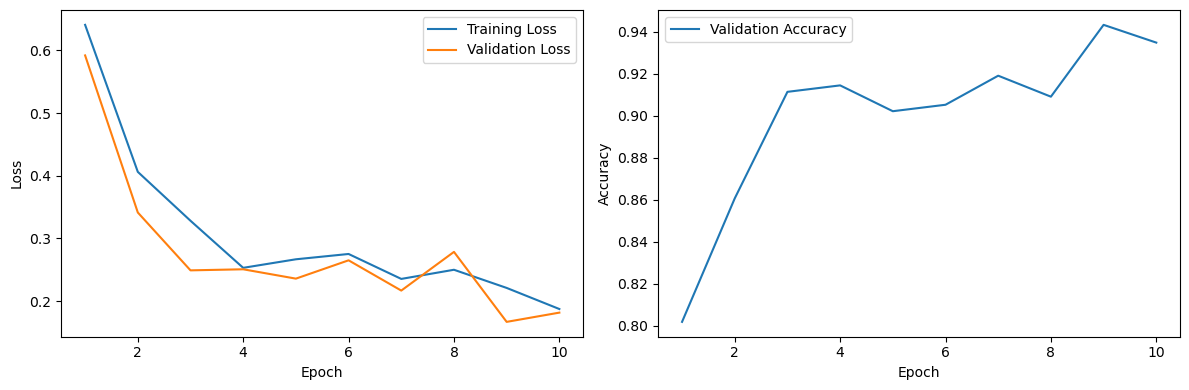

In [8]:
# Plot metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Load the best model weights
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [11]:
# Evaluate the model on the test set
model.eval()
test_correct_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for test_images, test_labels in tqdm(test_loader, desc="Testing", unit="batch"):
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_images)
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct_predictions += (test_predicted == test_labels).sum().item()

        all_predictions.extend(test_predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

test_accuracy = test_correct_predictions / len(test_dataset)
num_errors = np.sum(np.array(all_labels) != np.array(all_predictions))

print(classification_report(all_labels, all_predictions, target_names=train_dataset.dataset.classes))
print(f'There were {num_errors} errors in {len(all_predictions)} tests for an accuracy of {test_accuracy*100:6.2f}%')

Testing: 100%|██████████| 86/86 [00:37<00:00,  2.29batch/s]

                             precision    recall  f1-score   support

         Corn___Common_Rust       1.00      1.00      1.00       200
      Corn___Gray_Leaf_Spot       0.97      0.93      0.95       200
             Corn___Healthy       0.99      1.00      0.99       200
Corn___Northern_Leaf_Blight       0.93      0.97      0.95       200
      Potato___Early_Blight       1.00      0.98      0.99       200
           Potato___Healthy       0.99      1.00      1.00       152
       Potato___Late_Blight       0.99      0.99      0.99       200
          Rice___Brown_Spot       0.84      0.76      0.80       200
             Rice___Healthy       0.81      0.97      0.88       200
          Rice___Leaf_Blast       0.80      0.71      0.75       200
          Rice___Neck_Blast       1.00      1.00      1.00       200
         Wheat___Brown_Rust       0.98      1.00      0.99       200
            Wheat___Healthy       1.00      0.97      0.98       200
        Wheat___Yellow_Rust      

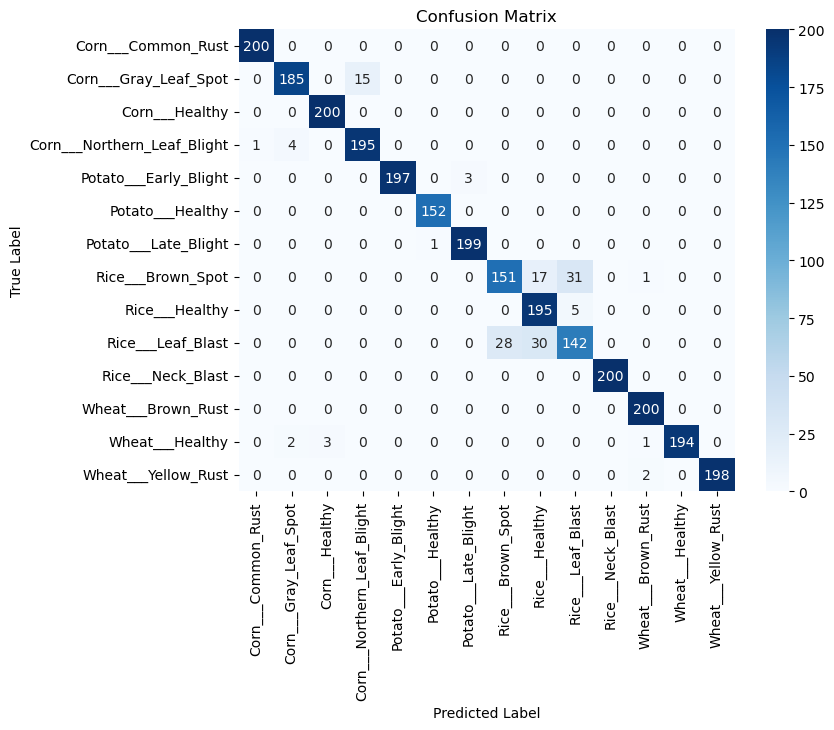

In [14]:
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()